<a href="https://colab.research.google.com/github/Shiva1906/DeepLearning/blob/GAN/GAN/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implementation of WGAN

##Installing required packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as Transforms
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2

##Config variables

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 2e-5
epochs = 5
noise_dim = 768
img_channels = 1
img_size = 64
z_dim = 100
features_d = 64
features_g = 64
batch_size = 64
critic_iteration = 5
weight_clp = 0.01

##Downloading Datasets and Creating Dataloader for Train and Test



In [3]:
transforms = torchvision.transforms.Compose([Transforms.Resize(img_size),
                                             Transforms.ToTensor(),
                                             Transforms.Normalize([0.5 for _ in range(img_channels)],[0.5 for _ in range(img_channels)]),
                                             ]
                                            )
train_data = datasets.MNIST(root="data",train=True,transform=transforms,download=True)
test_data = datasets.MNIST(root="data",train=False,transform=transforms,download=True)

train_dataloader = DataLoader(train_data,batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=64,shuffle=False)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.58MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.12MB/s]


##Discrimintor Model

In [4]:
class Discriminator(nn.Module):
  def __init__(self,img_channels=3,features_d=64):
    super(Discriminator,self).__init__()
    self.disc = nn.Sequential(
        nn.Conv2d(img_channels,features_d,kernel_size=4,stride=2,padding=1),
        nn.LeakyReLU(0.2),
        self._block(features_d,features_d*2,4,2,1),
        self._block(features_d*2,features_d*4,4,2,1),
        self._block(features_d*4,features_d*8,4,2,1),
        nn.Conv2d(features_d*8,1,kernel_size=4,stride=2,padding=0),
        nn.Sigmoid()
    )
  def _block(self,in_channels,out_channels,kernel_size,stride,padding):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )
  def forward(self,x):
    return self.disc(x)


##Generator Model

In [5]:
class Generator(nn.Module):
  def __init__(self,z_dim,features_g,img_channels):
    super(Generator,self).__init__()
    self.gen = nn.Sequential(
        self._block(z_dim,features_g*16,4,2,0),
        self._block(features_g*16,features_g*8,4,2,1),
        self._block(features_g*8,features_g*4,4,2,1),
        self._block(features_g*4,features_g*2,4,2,1),
        nn.ConvTranspose2d(features_g*2,img_channels,kernel_size=4,stride=2,padding=1),
        nn.Tanh()
    )
  def _block(self,in_channels,out_channels,kernel_size,stride,padding):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

  def forward(self,x):
      return self.gen(x)

##Initialize Weights

In [6]:
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m,(nn.Conv2d,nn.ConvTranspose2d,nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data,0.0,0.02)

##Training

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [0/5] Batch 0/938           Loss D: -0.1744, loss G: -0.5015


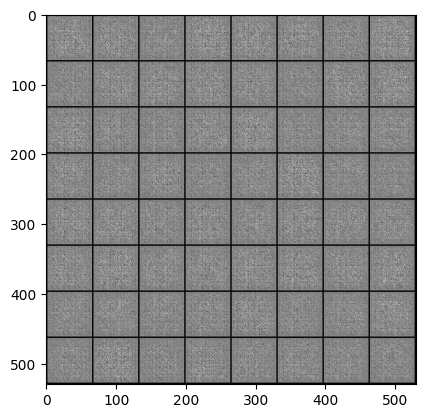

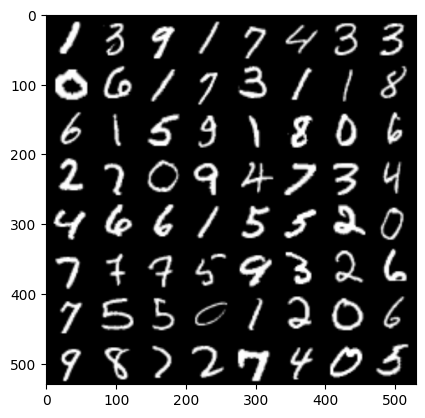

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [1/5] Batch 0/938           Loss D: -0.3736, loss G: -0.3206


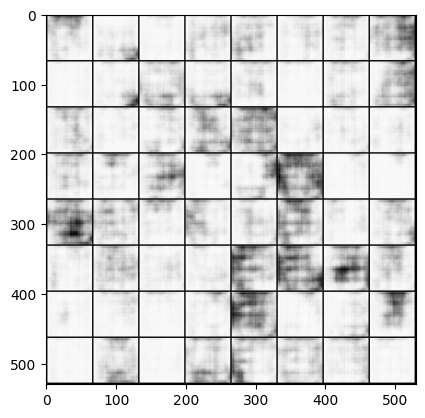

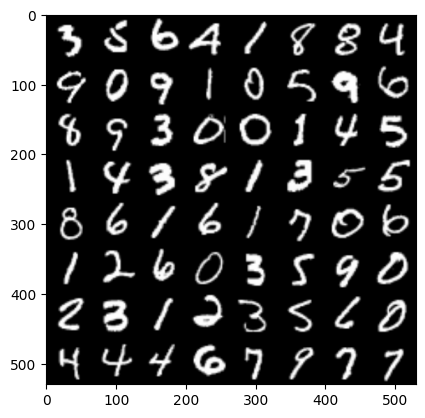

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [2/5] Batch 0/938           Loss D: -0.3741, loss G: -0.3206


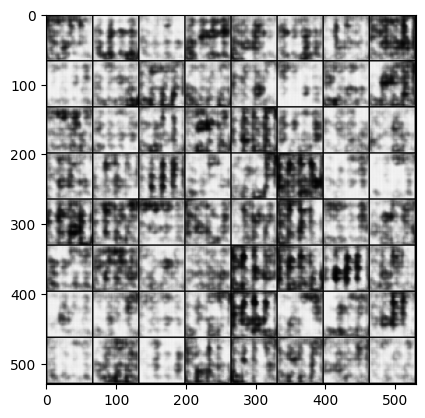

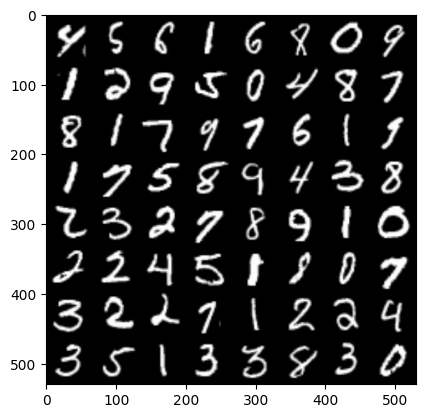

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [3/5] Batch 0/938           Loss D: -0.3674, loss G: -0.3216


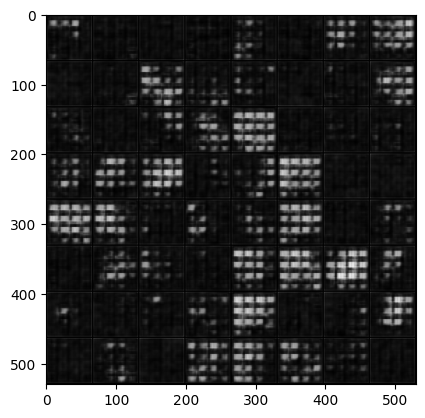

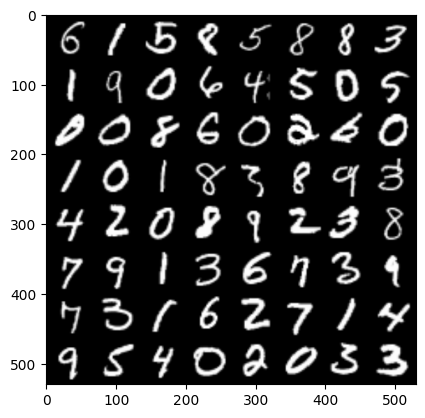

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [4/5] Batch 0/938           Loss D: -0.3735, loss G: -0.3208


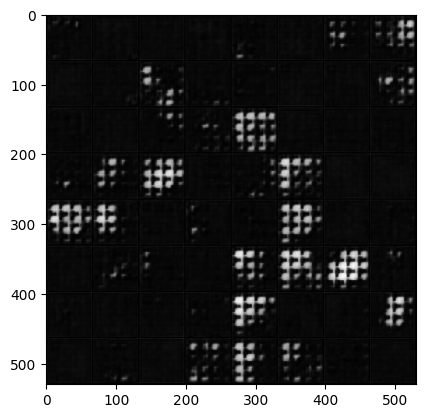

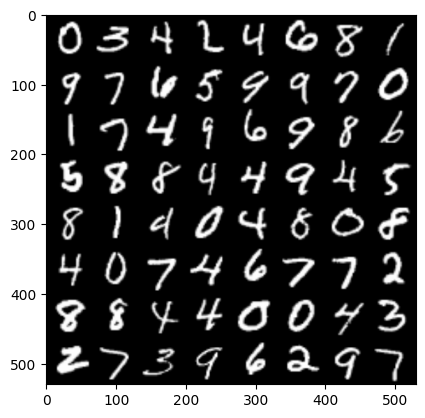

100%|██████████| 938/938 [06:31<00:00,  2.40it/s]


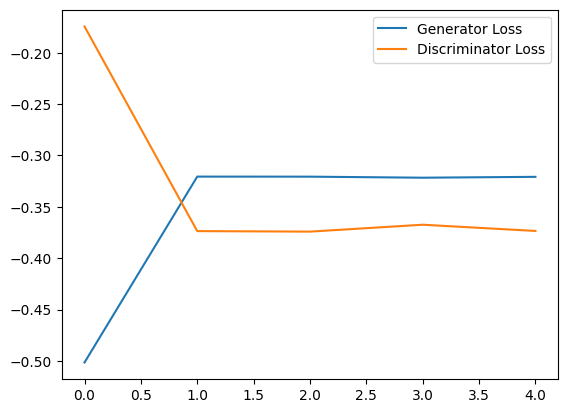

In [8]:

gen = Generator(z_dim=z_dim,features_g=features_g,img_channels=img_channels).to(device)
disc = Discriminator(features_d=features_d,img_channels=img_channels).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = torch.optim.RMSprop(gen.parameters(),lr=lr)
opt_disc = torch.optim.RMSprop(disc.parameters(),lr=lr)
fixed_noise = torch.randn((64,z_dim))

disc.train()
gen.train()

losses_g = []
losses_d = []

for epoch in range(epochs):
  for batch_idx,(real,_) in enumerate(tqdm(train_dataloader)):
    real = real.to(device)
    noise = torch.randn((batch_size,z_dim,1,1)).to(device)
    fake = gen(noise)
    for _ in range(0,critic_iteration):
      disc_real = disc(real)
      dis_fake = disc(fake)
      lossD = -(torch.mean(disc_real) - torch.mean(dis_fake))
      disc.zero_grad()
      lossD.backward(retain_graph=True)
      opt_disc.step()

    for p in disc.parameters():
      p.data.clamp_(-weight_clp,weight_clp)

    output = disc(fake).view(-1)
    lossG = -torch.mean(output)
    gen.zero_grad()
    lossG.backward()
    opt_gen.step()

    if batch_idx == 0:
      print(
          f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(train_dataloader)} \
          Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
      )
      losses_g.append(lossG.item())
      losses_d.append(lossD.item())

      with torch.no_grad():
        fake = gen(fixed_noise.reshape(-1,z_dim,1,1).to(device)).reshape(-1,1,img_size,img_size)
        data = real.reshape(-1,1,img_size,img_size)
        img_grid_fake = torchvision.utils.make_grid(fake,normalize=True)
        img_grid_real = torchvision.utils.make_grid(data,normalize=True)
        plt.imshow(img_grid_fake.cpu().detach().numpy().transpose(1,2,0))
        plt.show()
        plt.imshow(img_grid_real.cpu().detach().numpy().transpose(1,2,0))
        plt.show()
plt.plot(losses_g,label="Generator Loss")
plt.plot(losses_d,label="Discriminator Loss")
plt.legend()
plt.show()

## #Need to train for more epochs